In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [6]:
syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

In [7]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [8]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

,en,au,ce,cj,ah,bm,ch,ai,db,aj,ck,hg,ac,ci,fq,ec,df,bx,cr,cl
0,2995,2077,1620,1506,1418,1379,1363,1362,1358,1305,1233,1180,1179,1080,1007,1003,986,984,978,971


In [9]:
sylllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

In [10]:
sylllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
12,114.757543,114.986067,bm,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.03662450122476042, -0.022604548403189744, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [11]:
sylllable_df = sylllable_df.reset_index()

In [12]:
specs = np.array(list(sylllable_df.spectrogram.values))
specs.shape

(26984, 32, 31)

In [13]:
sylllable_df['subset'] = 'train'
sylllable_df.loc[:1000, 'subset'] = 'valid'
sylllable_df.loc[1000:1999, 'subset'] = 'test'

In [14]:
len(sylllable_df)

26984

In [15]:
Y_train = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'train']))
Y_valid = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'valid']))
Y_test = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'test']))

In [16]:
X_train = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'test'])) #/ 255.

In [17]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()

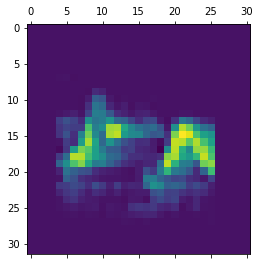

In [19]:
plt.matshow(X_train[10])

### Train PCA model

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=64)

In [22]:
z = pca.fit_transform(X_train_flat)

### plot output

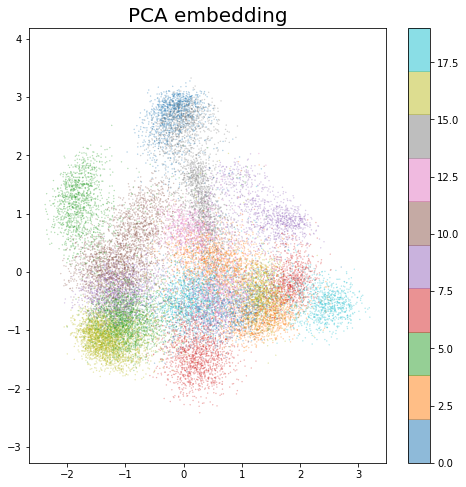

In [23]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("PCA embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save model

In [24]:
import os
import pickle

In [25]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [26]:
output_dir = MODEL_DIR/'projections'/ 'cassins_dtw'/ '64' / 'PCA'
ensure_dir(output_dir)

In [27]:
with open(os.path.join(output_dir, "model.pkl"), "wb") as output:
    pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)

In [28]:
np.save(output_dir / 'z.npy', z)

## tsne

In [29]:
from openTSNE import TSNE

In [30]:
tsne = TSNE(
    n_components = 64,
    negative_gradient_method = 'bh'
)

In [31]:
embedding_train = tsne.fit(X_train_flat)

KeyboardInterrupt: 

In [ ]:
z = np.array(embedding_train)

In [ ]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("PCA embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

#### save model

In [ ]:
import os
import pickle

from tfumap.paths import ensure_dir, MODEL_DIR

output_dir = MODEL_DIR/'projections'/ 'cassins_dtw'/ '64' / 'TSNE'
ensure_dir(output_dir)

with open(os.path.join(output_dir, "model.pkl"), "wb") as output:
    pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)

np.save(output_dir / 'z.npy', z)